<a href="https://colab.research.google.com/github/pranay8297/fastaip2/blob/main/convolutions_and_learner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic Requirements

In [ ]:
!pip install datasets
!pip install ipdb
!pip install torcheval

In [2]:
import torch
import datasets
import math
import matplotlib.pyplot as plt
from ipdb import set_trace as st

import pandas as pd
import numpy as np

import matplotlib as mpl
from pathlib import Path
from datasets import load_dataset, load_dataset_builder
from torchvision.transforms.functional import to_tensor

from PIL import Image
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch import nn
from operator import itemgetter, attrgetter, methodcaller
from torch import optim
import fastcore.all as fc
from tqdm import tqdm
from torcheval.metrics import MulticlassAccuracy, Mean, MulticlassF1Score
from collections.abc import Mapping
from functools import partial

mpl.rcParams['image.cmap'] = 'gray'

In [3]:
def show_image(im, ax = None, figsize = (3, 3), title = None, **kwargs):

  if len(im.shape) > 2 and im.shape[0] == 1: im = im.squeeze()

  im = im.numpy()
  if not ax: _, ax = plt.subplots(1, 1, figsize = figsize)
  ax.imshow(im, **kwargs)
  if title: ax.set_title(title)
  ax.axis('off')
  return ax

def get_grid(n_images, n_rows = None, n_cols = None, **kwargs):

  if n_rows and n_cols: nr, nc = n_rows, n_cols
  elif n_rows and not n_cols: nr, nc = n_rows, math.ceil(n_images/n_rows)
  elif n_cols and not n_rows: nr, nc = math.ceil(n_images/n_cols), n_cols
  else: nr, nc = math.ceil(n_images/4), 4
  fig, axs = plt.subplots(nr, nc, **kwargs)
  if nr*nc == 1: axs = [axs]
  for i in range(n_images, nr*nc): axs.flat[i].set_axis_off()
  return fig, axs.flatten()

def display_pixels(im_tensor):
  df = pd.DataFrame(im_tensor.squeeze())
  df.style.format(precision = 2).set_properties(**{"font-size": '7pt'}).background_gradient('Greys')

In [4]:
def show_images(images, labels = None):

  fig, axs = get_grid(len(images))
  labels = labels if labels else [None]*len(images)
  for img, ax, lbl in zip(images, axs, labels): show_image(img, ax, title = lbl)

In [5]:
# Prepare the model
def conv(n_in, n_out, kernel_size = (3, 3), stride = 2, relu = True):
  layer = nn.Conv2d(n_in, n_out, kernel_size, stride = stride, padding = kernel_size[0]//2)
  if relu: return nn.Sequential(layer, nn.ReLU())
  return layer

def fit(model, num_epocs = 100, lr = 0.01, optim = None, loss_fun = None):

  opt = torch.optim.SGD(model.parameters(), lr = lr) if not optim  else optim(model.parameters(), lr = lr)
  loss_fn = F.cross_entropy if not loss_fun else loss_fun

  for i in tqdm(range(num_epocs)):
    model.train()
    train_losses, valid_losses = [], []
    for x, y in train_dl:
      x, y = x.to(device), y.to(device)
      yhat = model(x)
      loss = loss_fn(yhat, y)
      loss.backward()
      # st()
      opt.step()
      opt.zero_grad()

      train_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
      for vx, vy in valid_dl:
        vx, vy = vx.to(device), vy.to(device)
        vyhat = model(vx)
        vloss = loss_fn(vyhat, vy)
        valid_losses.append(vloss.item())

    print(f"epoch: {i}, train_loss: {np.mean(train_losses)}, valid_loss: {np.mean(valid_losses)}")

In [6]:
def to_device(data, device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')):
  return data.to(device)

def run_cbs(cbs, name_of_func, *args, **kwargs):
  for cb in sorted(cbs, key = attrgetter('order')):
    func = getattr(cb, name_of_func, None)
    if func: func(*args, **kwargs)

def to_cpu(x):
  if isinstance(x, Mapping): return {k: to_cpu(v) for k, v in x.items()}
  if isinstance(x, list): return [to_cpu(i) for i in x]
  if isinstance(x, tuple): return tuple([to_cpu(i) for i in x])
  x = x.detach().cpu()
  return x.float() if x.dtype == torch.float16 else x

class Callback: order = 0

In [7]:
x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

def new(some_data):
  def transform(some_data):
    some_data['image'] = [to_tensor(i) for i in some_data['image']]
  transform(some_data)

  return some_data

def collate_fn(some_data):
  sd = (i.values() for i in some_data)
  xs, ys = zip(*sd)
  return torch.stack(xs), torch.tensor(ys)

tds = dsd.with_transform(new)
f = partial(DataLoader, batch_size = 64, collate_fn = collate_fn)
train_dl, valid_dl = f(tds['train'], shuffle = True), f(tds['test'])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

# MNIST and Convolutions

In [ ]:
ds_builder = load_dataset_builder('mnist')

In [ ]:
ds = load_dataset('mnist')

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

<Axes: >

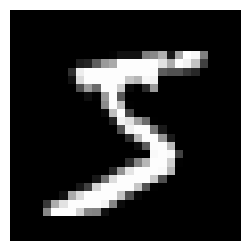

In [ ]:
img = ds['train']['image'][0]
im_tensor = to_tensor(img)
show_image(im_tensor)

In [ ]:
kernel = torch.Tensor([
    [-1, -1, -1],
    [0, 0, 0],
    [1, 1, 1]
]).float()

<Axes: >

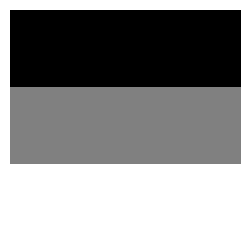

In [ ]:
show_image(kernel)

In [ ]:
df = pd.DataFrame(im_tensor.squeeze())

In [ ]:
df.style.format(precision = 2).set_properties(**{"font-size": '7pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.07,0.07,0.07,0.49,0.53,0.69,0.10,0.65,1.00,0.97,0.50,0.00,0.00,0.00,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.12,0.14,0.37,0.60,0.67,0.99,0.99,0.99,0.99,0.99,0.88,0.67,0.99,0.95,0.76,0.25,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.19,0.93,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.98,0.36,0.32,0.32,0.22,0.15,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.07,0.86,0.99,0.99,0.99,0.99,0.99,0.78,0.71,0.97,0.95,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.31,0.61,0.42,0.99,0.99,0.80,0.04,0.00,0.17,0.60,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [ ]:
im_tensor.squeeze_()
im_tensor.shape

torch.Size([28, 28])

In [ ]:
im_tensor[3:6, 20:23].shape

torch.Size([3, 3])

In [ ]:
im_tensor[25:28].shape

torch.Size([3, 28])

In [ ]:
def apply_kernel(im_tensor, kernel = kernel): return (im_tensor * kernel).sum()

In [ ]:
apply_kernel(im_tensor[3:6, 20:23])

tensor(2.6196)

In [ ]:
def conv_img(im_tensor, kernel = kernel):
  im_tensor.squeeze_()
  (rows, cols), margin = im_tensor.shape, kernel.shape[0]
  return torch.stack([torch.Tensor([apply_kernel(im_tensor[r:r+margin, c:c+margin], kernel) for c in range(cols - margin)]) for r in range(rows - margin)])

In [ ]:
acts = conv_img(im_tensor)

<Axes: >

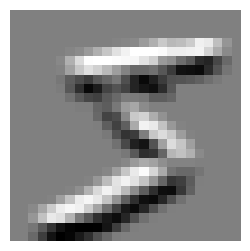

In [ ]:
show_image(acts)

In [ ]:
left_edge = torch.Tensor([
    [-1, 0, 1],
    [-1, 0, 1],
    [-1, 0, 1]
]).float()

<Axes: >

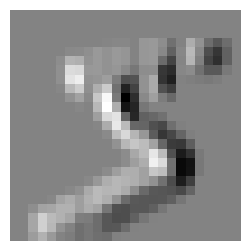

In [ ]:
show_image(conv_img(im_tensor, left_edge))

In [ ]:
im_tensor[None, None, :, :].shape

torch.Size([1, 1, 28, 28])

In [ ]:

F.unfold(im_tensor[None, None, :, :], (3, 3)).shape

torch.Size([1, 9, 676])

In [ ]:
ext = torch.tensor([[1.1, 1.2, 1.3, 1.4, 1.5],
                    [2.1, 2.2, 2.3, 2.4, 2.5],
                    [3.1, 3.2, 3.3, 3.4, 3.5],
                    [4.1, 4.2, 4.3, 4.4, 4.5],
                    [5.1, 5.2, 5.3, 5.4, 5.5],
                    [6.1, 6.2, 6.3, 6.4, 6.5]]).float()
F.unfold(ext[None, None, :, :], (3, 3))

tensor([[[1.1000, 1.2000, 1.3000, 2.1000, 2.2000, 2.3000, 3.1000, 3.2000,
          3.3000, 4.1000, 4.2000, 4.3000],
         [1.2000, 1.3000, 1.4000, 2.2000, 2.3000, 2.4000, 3.2000, 3.3000,
          3.4000, 4.2000, 4.3000, 4.4000],
         [1.3000, 1.4000, 1.5000, 2.3000, 2.4000, 2.5000, 3.3000, 3.4000,
          3.5000, 4.3000, 4.4000, 4.5000],
         [2.1000, 2.2000, 2.3000, 3.1000, 3.2000, 3.3000, 4.1000, 4.2000,
          4.3000, 5.1000, 5.2000, 5.3000],
         [2.2000, 2.3000, 2.4000, 3.2000, 3.3000, 3.4000, 4.2000, 4.3000,
          4.4000, 5.2000, 5.3000, 5.4000],
         [2.3000, 2.4000, 2.5000, 3.3000, 3.4000, 3.5000, 4.3000, 4.4000,
          4.5000, 5.3000, 5.4000, 5.5000],
         [3.1000, 3.2000, 3.3000, 4.1000, 4.2000, 4.3000, 5.1000, 5.2000,
          5.3000, 6.1000, 6.2000, 6.3000],
         [3.2000, 3.3000, 3.4000, 4.2000, 4.3000, 4.4000, 5.2000, 5.3000,
          5.4000, 6.2000, 6.3000, 6.4000],
         [3.3000, 3.4000, 3.5000, 4.3000, 4.4000, 4.5000, 5.3000

In [ ]:
F.unfold(ext[None, None, :, :], (3, 3)).shape

torch.Size([1, 9, 12])

In [ ]:
imgs = ds['train']['image'][:8]
imgs = torch.stack(list(map(to_tensor, imgs)))

In [ ]:
kernels = torch.stack((kernel, left_edge))[:, None, :, :]

In [ ]:
imgs.shape, kernels.shape

(torch.Size([8, 1, 28, 28]), torch.Size([2, 1, 3, 3]))

In [ ]:
out = F.conv2d(imgs, kernels)
out.shape

torch.Size([8, 2, 26, 26])

<Axes: >

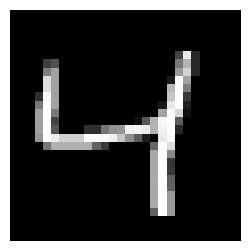

In [ ]:
show_image(imgs[2])

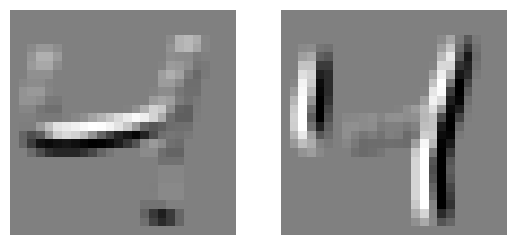

In [ ]:
fig, axs = get_grid(2, 1, 2)
for i, ax in enumerate(axs):
  show_image(out[2, i], ax)

In [ ]:
from torch.utils.data import DataLoader
from torch import nn

In [ ]:
def transform(some_data):
  some_data['image'] = [to_tensor(img) for img in some_data['image']]
  return some_data

def collate_function(some_data):
  data = [(s['image'], torch.tensor(s['label'])) for s in some_data]
  x, y = zip(*data)
  return torch.stack(x), torch.stack(y)

In [ ]:
# Prepare the dataloaders
# Prepare the model
# Train the model for 10 epochs
train_ds, test_ds = ds['train'].with_transform(transform), ds['test'].with_transform(transform)
train_dl, valid_dl = DataLoader(train_ds, batch_size = 64, shuffle = True, collate_fn = collate_function), DataLoader(test_ds, batch_size = 16, shuffle = False, collate_fn = collate_function)

In [ ]:
# Prepare the model
def conv(n_in, n_out, kernel_size = (3, 3), stride = 2, relu = True):
  layer = nn.Conv2d(n_in, n_out, kernel_size, stride = stride, padding = kernel_size[0]//2)
  if relu: return nn.Sequential(layer, nn.ReLU())
  return layer

In [ ]:
device = torch.device('cuda')

In [ ]:

def test_fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb,yb in train_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

        model.eval()
        with torch.no_grad():
            tot_loss,tot_acc,count = 0.,0.,0
            for xb,yb in valid_dl:
                pred = model(xb)
                n = len(xb)
                count += n
                tot_loss += loss_func(pred,yb).item()*n
                tot_acc  += accuracy (pred,yb).item()*n
        print(epoch, tot_loss/count, tot_acc/count)
    return tot_loss/count, tot_acc/count

In [ ]:
x, y = next(iter(train_dl))

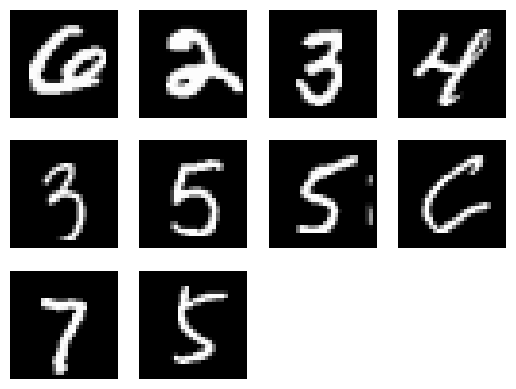

In [ ]:
fig, axs = get_grid(10, 3)
imgs = x[:10]
for img, ax in zip(imgs, axs):
  show_image(img, ax)

In [ ]:
y[:10]

tensor([6, 2, 3, 4, 3, 5, 5, 6, 7, 5])

In [ ]:
def get_model():
  return nn.Sequential(
    conv(1, 8),  ## 8x14x14
    conv(8, 16), ## 16x7x7
    conv(16, 32), ## 32x4x4
    conv(32, 16), # 64x2x2
    conv(16, 10, relu = False), # 128x1x1
    nn.Flatten(), # bs x 128
  ).to(device)

model = get_model()

In [ ]:
new_model = nn.Sequential(
    conv(1 ,4),            #14x14
    conv(4 ,8),            #7x7
    conv(8 ,16),           #4x4
    conv(16,16),           #2x2
    conv(16,10, relu=False), #1x1
    nn.Flatten(),
).to(device)

In [ ]:
class MyModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = nn.Sequential(
      conv(1, 8),  ## 8x14x14
      conv(8, 16), ## 16x7x7
      conv(16, 32), ## 32x4x4
      conv(32, 64), # 64x2x2
      conv(64, 128)
    )
    self.final = nn.Sequential(nn.Linear(128, 10), nn.ReLU())

  def forward(self, x):
    x = self.encoder(x).view(x.shape[0], -1)
    return self.final(x)


In [ ]:

def fit(model = model, num_epocs = 100, lr = 0.01):

  opt = torch.optim.SGD(model.parameters(), lr = lr)
  loss_fn = F.cross_entropy

  for i in range(num_epocs):
    model.train()
    train_losses, valid_losses = [], []
    for x, y in train_dl:
      x, y = x.to(device), y.to(device)
      yhat = model(x)
      loss = loss_fn(yhat, y)
      loss.backward()
      opt.step()
      opt.zero_grad()

      train_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
      for vx, vy in valid_dl:
        vx, vy = vx.to(device), vy.to(device)
        vyhat = model(vx)
        vloss = loss_fn(vyhat, vy)
        valid_losses.append(vloss.item())

    print(f"epoch: {i}, train_loss: {np.mean(train_losses)}, valid_loss: {np.mean(valid_losses)}")

In [ ]:
fit(model = new_model, num_epocs = 3, lr = 0.1)

epoch: 0, train_loss: 1.3915640050048894, valid_loss: 0.28255949592851104
epoch: 1, train_loss: 0.19294885002862988, valid_loss: 0.1232951137450058
epoch: 2, train_loss: 0.13124457460496503, valid_loss: 0.1556387377347797


In [ ]:
model_v3 = nn.Sequential(
    conv(1, 4),  ## 8x14x14
    conv(4, 8), ## 16x7x7
    conv(8, 16), ## 32x4x4
    conv(16, 32), # 64x2x2
    conv(32, 64), # 128x1x1
    nn.Flatten(), # bs x 128
    nn.Linear(64, 10),
    nn.ReLU()
  ).to(device)
fit(model = model_v3, num_epocs = 3, lr = 0.1)

epoch: 0, train_loss: 2.3015400791473226, valid_loss: 2.3004445514678955
epoch: 1, train_loss: 1.7015047817786872, valid_loss: 0.3560440572410822
epoch: 2, train_loss: 0.1938174391445368, valid_loss: 0.13029525599107147


In [ ]:
model_v4 = nn.Sequential(
    conv(1, 8),  ## 8x14x14
    conv(8, 16), ## 16x7x7
    conv(16, 32), ## 32x4x4
    conv(32, 64), # 64x2x2x
    conv(64, 64), # 128x1x1
    nn.Flatten(), # bs x 128
    nn.Linear(64, 10),
    nn.ReLU()
  ).to(device)
fit(model = model_v4, num_epocs = 3, lr = 0.1)

epoch: 0, train_loss: 2.2928247206500854, valid_loss: 1.9957037464141845
epoch: 1, train_loss: 0.39728973281861685, valid_loss: 0.3145681996891275
epoch: 2, train_loss: 0.1182014906842476, valid_loss: 0.09782285843869903


In [ ]:
model_v5 = nn.Sequential(
    conv(1, 8),  ## 8x14x14
    conv(8, 16), ## 16x7x7
    conv(16, 32), ## 32x4x4
    conv(32, 64), # 64x2x2x
    conv(64, 128), # 128x1x1
    nn.Flatten(), # bs x 128
    nn.Linear(128, 10),
    nn.ReLU()
  ).to(device)
fit(model = model_v5, num_epocs = 3, lr = 0.1)

epoch: 0, train_loss: 1.1705503302143772, valid_loss: 0.1985379087826237
epoch: 1, train_loss: 0.1353729552656873, valid_loss: 0.09797595009910874
epoch: 2, train_loss: 0.08780057390661303, valid_loss: 0.17738789424971327


# Autoencoder and experiments

In [ ]:
# start with showing images
# get the new dataset
# Create a new dataset, dataloaders with collate function and all
# Create an auto encoder - basic unet, play around, add skip connections and all - Add hooks and all.
# Test them with SGD, Adam

In [ ]:
dsd = load_dataset_builder('fashion_mnist')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
ds = load_dataset('fashion_mnist')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [ ]:
dsd, ds

(<datasets.packaged_modules.parquet.parquet.ParquetFashionMnist at 0x7eee071b7ca0>,
 DatasetDict({
     train: Dataset({
         features: ['image', 'label'],
         num_rows: 60000
     })
     test: Dataset({
         features: ['image', 'label'],
         num_rows: 10000
     })
 }))

In [ ]:
class FM_Dataset(Dataset):
  def __init__(self, x, y):
    super().__init__()
    if type(x) == list: x = torch.stack(x)
    if type(y) == list: y = torch.tensor(y, dtype = torch.long)
    self.x, self.y = x, y

  def __getitem__(self, index):
    return self.x[index], self.y[index]

  def __len__(self):
    return self.x.shape[0]

In [ ]:
def collate_fn(data):
  x, y = zip(*data)
  return torch.stack(x), torch.stack(y)

def conv(nin, nout, ks = (3,3), stride = 2, act = False):
  layer = nn.Conv2d(nin, nout, ks, stride, padding = ks[0]//2)
  if act: return nn.Sequential(layer, nn.ReLU())
  return layer

train_x, train_y, test_x, test_y = ds['train']['image'], ds['train']['label'], ds['test']['image'], ds['test']['label']
train_x, test_x = torch.stack(list(map(to_tensor, train_x))), torch.stack(list(map(to_tensor, test_x)))
train_ds, valid_ds = FM_Dataset(train_x, train_y), FM_Dataset(test_x, test_y)
train_dl, valid_dl = DataLoader(train_ds, batch_size = 64, shuffle = True, collate_fn = collate_fn), DataLoader(valid_ds, batch_size = 64, shuffle = False, collate_fn = collate_fn)

In [ ]:
device = torch.device('cuda')

In [ ]:
model = nn.Sequential(
    conv(1, 8), # (14, 14)
    conv(8, 16), # (7, 7)
    conv(16, 32), # (4, 4)
    conv(32, 64), # (2, 2)
    conv(64, 128),  # (1, 1)
    nn.Flatten(),
    nn.Linear(128, 10),
    nn.ReLU()
).to(device)

In [ ]:
fit(model, 8, lr = 0.1)

epoch: 0, train_loss: 0.8408869242172505, valid_loss: 0.6652135562365222
epoch: 1, train_loss: 0.5208437432453576, valid_loss: 0.5358633603070192
epoch: 2, train_loss: 0.4915948046137021, valid_loss: 0.5149278254455821
epoch: 3, train_loss: 0.4706609522991343, valid_loss: 0.48339534014653246
epoch: 4, train_loss: 0.4568423995140519, valid_loss: 0.4737347679533017
epoch: 5, train_loss: 0.44619870557586777, valid_loss: 0.48947655784476335
epoch: 6, train_loss: 0.44074667025921443, valid_loss: 0.4806534168636723
epoch: 7, train_loss: 0.43502002184007216, valid_loss: 0.482069139457812


In [ ]:
sx = torch.randn(16, 8, 7, 7)
sl = nn.UpsamplingNearest2d(scale_factor=2)
sl(sx).shape

torch.Size([16, 8, 14, 14])

In [ ]:
def de_conv(nin, nout, ks = 3, stride = 1, relu = True):
  layers = [nn.UpsamplingNearest2d(scale_factor=2), nn.Conv2d(nin, nout, (ks, ks), stride, padding = ks//2)]
  if relu: layers.append(nn.ReLU())
  return nn.Sequential(*layers)

In [ ]:
autoencoder = nn.Sequential(
    nn.ZeroPad2d(2),
    conv(1, 2), # (14, 14)
    conv(2, 4), # (7, 7)
    conv(4, 8), # (4, 4)
    de_conv(8, 4), # (8, 8)
    de_conv(4, 2), # (16, 16)
    de_conv(2, 1), # (32, 32)
    nn.ZeroPad2d(-2),
).to(device)

In [ ]:
def ae_fit(model, dl, valid_dl, loss_fn, optim, epocs = 10):
  # with torch.autocast():
  for ep in range(epocs):
    train_loss, valid_loss = [], []
    for x, y in dl:
      x = x.to(device)
      yhat = model(x)
      loss = loss_fn(yhat, x)
      loss.backward()
      optim.step()
      optim.zero_grad()
      train_loss.append(loss.item())

    with torch.no_grad():
      for vx, vy in valid_dl:
        vx = vx.to(device)
        vyhat = model(vx)
        vloss = loss_fn(vyhat, vx)
        valid_loss.append(vloss.item())
    print(f'train_loss: {np.mean(train_loss):.4f}, valid_loss: {np.mean(valid_loss):.4f}')

In [ ]:
loss_fn = F.mse_loss
optim = torch.optim.SGD(autoencoder.parameters(), lr = 0.01)
ae_fit(autoencoder, train_dl, valid_dl, loss_fn, optim)

train_loss: 0.0891, valid_loss: 0.0409
train_loss: 0.0361, valid_loss: 0.0336
train_loss: 0.0324, valid_loss: 0.0314
train_loss: 0.0307, valid_loss: 0.0300
train_loss: 0.0295, valid_loss: 0.0291
train_loss: 0.0287, valid_loss: 0.0283
train_loss: 0.0280, valid_loss: 0.0277
train_loss: 0.0275, valid_loss: 0.0272
train_loss: 0.0270, valid_loss: 0.0267
train_loss: 0.0265, valid_loss: 0.0263


In [ ]:
# First lets change the optimization from SGD to AdamW - firstly whats the difference between Adam and AdamW? - Done
# Try adding shape connections - register hooks, and get outputs, and then add them - Done
# Add Batch Norm Layers - Done
# Add skip connections - ResLayers - Experiment them - Done

In [ ]:
autoencoder = nn.Sequential(
    nn.ZeroPad2d(2),
    conv(1, 2), # (14, 14)
    conv(2, 4), # (7, 7)
    conv(4, 8), # (4, 4)
    de_conv(8, 4), # (8, 8)
    de_conv(4, 2), # (16, 16)
    de_conv(2, 1), # (32, 32)
    nn.ZeroPad2d(-2),
).to(device)

loss_fn = F.mse_loss
optim = torch.optim.AdamW(autoencoder.parameters(), lr = 1e-03, betas = (0.9, 0.9), weight_decay = 1e-01)
ae_fit(autoencoder, train_dl, valid_dl, loss_fn, optim)

train_loss: 0.0297, valid_loss: 0.0194
train_loss: 0.0179, valid_loss: 0.0167
train_loss: 0.0160, valid_loss: 0.0156
train_loss: 0.0151, valid_loss: 0.0150
train_loss: 0.0148, valid_loss: 0.0147
train_loss: 0.0146, valid_loss: 0.0146
train_loss: 0.0144, valid_loss: 0.0144
train_loss: 0.0143, valid_loss: 0.0144
train_loss: 0.0142, valid_loss: 0.0144
train_loss: 0.0142, valid_loss: 0.0143


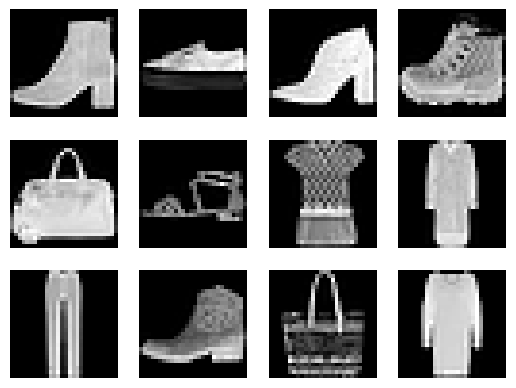

In [ ]:
x, y = next(iter(train_dl))
yhat = autoencoder(x.to(device)).to('cpu').detach()
show_images(x[:12])

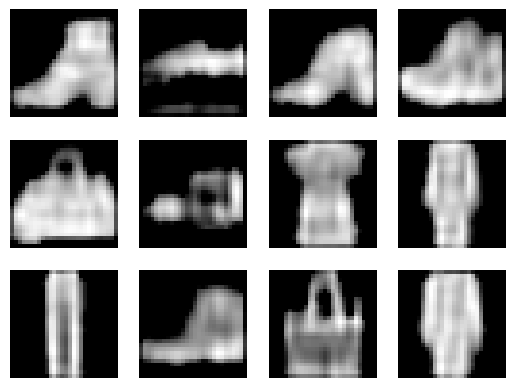

In [ ]:
old_yhat = yhat.clone()
show_images(yhat[:12])

In [ ]:
acts = {}

def get_hook_fn(name):
  def hook(model, inp, out):
    acts[name] = out
  return hook

class AE(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.ModuleList([nn.ZeroPad2d(2),
                conv(1, 2), # (14, 14)
                conv(2, 4), # (7, 7)
                conv(4, 8), # (4, 4)
                de_conv(8, 4), # (8, 8)
                de_conv(4, 2), # (16, 16)
                de_conv(2, 1), # (32, 32)
                nn.ZeroPad2d(-2)
              ])

    self.acts = {}
    self.layers[1].register_forward_hook(get_hook_fn('2'))
    self.layers[2].register_forward_hook(get_hook_fn('4'))
    self.layers[3].register_forward_hook(get_hook_fn('8'))

    self.enc = nn.Sequential(*self.layers[:4])

  def forward(self, x):
    int_acts = self.enc(x)
    int_acts = self.layers[4](int_acts + acts['8'])
    int_acts = self.layers[5](int_acts + acts['4'])
    int_acts = self.layers[6](int_acts + acts['2'])
    return self.layers[-1](int_acts)



In [ ]:
ae_model = AE().to(device)

In [ ]:
loss_fn = F.mse_loss
optim = torch.optim.AdamW(ae_model.parameters(), lr = 1e-03, betas = (0.9, 0.9), weight_decay = 1e-01)
ae_fit(ae_model, train_dl, valid_dl, loss_fn, optim)

train_loss: 0.0165, valid_loss: 0.0037
train_loss: 0.0034, valid_loss: 0.0033
train_loss: 0.0032, valid_loss: 0.0032
train_loss: 0.0032, valid_loss: 0.0032
train_loss: 0.0032, valid_loss: 0.0032
train_loss: 0.0032, valid_loss: 0.0032
train_loss: 0.0032, valid_loss: 0.0032
train_loss: 0.0032, valid_loss: 0.0032
train_loss: 0.0032, valid_loss: 0.0032
train_loss: 0.0032, valid_loss: 0.0032


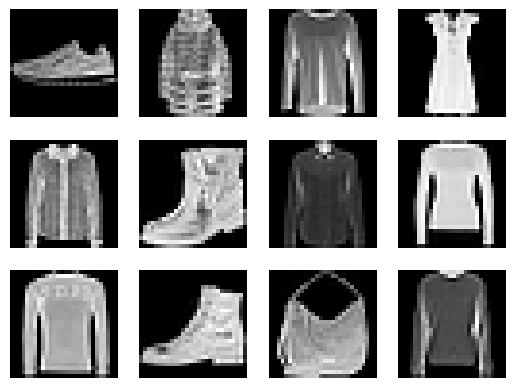

In [ ]:
x, y = next(iter(train_dl))
yhat = ae_model(x.to(device)).to('cpu').detach()
show_images(x[:12])

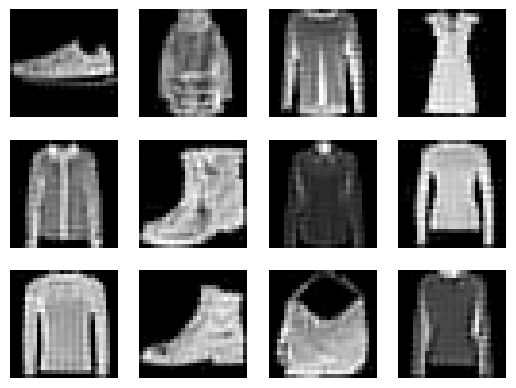

In [ ]:
show_images(yhat[:12])

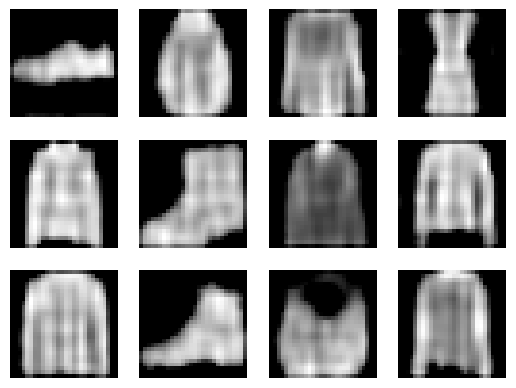

In [ ]:
yhat_prev_model = autoencoder(x.to(device)).detach().to('cpu')
show_images(yhat_prev_model[:12])

In [ ]:
# Lets create a ResLayer

In [ ]:
class ResLayer(nn.Module):
  def __init__(self, nin, nout, ks = 3, stride = 2):
    super().__init__()
    init_layers = []
    if stride == '1/2':
      self.do_st = True
      init_layers.append(de_conv(nin, nout, ks = ks))
      nin = nout
      stride = 1
    init_layers.append(conv(nin, nout, stride = stride))
    self.init_layers = nn.Sequential(*init_layers)
    self.fin_layers = nn.Sequential(conv(nout, nout, stride = 1), conv(nout, nout, stride = 1))

  def forward(self, x):
    # if self.do_st: st()
    x = self.init_layers(x)
    return self.fin_layers(x) + x

In [ ]:
acts = {}

def get_hook_fn(name):
  def hook(model, inp, out):
    acts[name] = out
  return hook

class AE(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.ModuleList([nn.ZeroPad2d(2),
                ResLayer(1, 2), # (16, 16)
                ResLayer(2, 4), # (8, 8)
                ResLayer(4, 8), # (4, 4)
                ResLayer(8, 4, stride = '1/2'), # (8, 8)
                ResLayer(4, 2, stride = '1/2'), # (16, 16)
                ResLayer(2, 1, stride = '1/2'), # (32, 32)
                nn.ZeroPad2d(-2)
              ])

    self.acts = {}
    self.layers[1].register_forward_hook(get_hook_fn('2'))
    self.layers[2].register_forward_hook(get_hook_fn('4'))
    self.layers[3].register_forward_hook(get_hook_fn('8'))

    self.enc = nn.Sequential(*self.layers[:4])

  def forward(self, x):
    int_acts = self.enc(x)
    int_acts = self.layers[4](int_acts + acts['8'])
    int_acts = self.layers[5](int_acts + acts['4'])
    int_acts = self.layers[6](int_acts + acts['2'])
    return self.layers[-1](int_acts)



In [ ]:
ae_v2 = AE().to(device)

In [ ]:
loss_fn = F.mse_loss
optim = torch.optim.AdamW(ae_v2.parameters(), lr = 1e-03, betas = (0.9, 0.9), weight_decay = 1e-01)
ae_fit(ae_v2, train_dl, valid_dl, loss_fn, optim)

train_loss: 0.0070, valid_loss: 0.0026
train_loss: 0.0024, valid_loss: 0.0023
train_loss: 0.0023, valid_loss: 0.0022
train_loss: 0.0022, valid_loss: 0.0022
train_loss: 0.0022, valid_loss: 0.0022
train_loss: 0.0021, valid_loss: 0.0021
train_loss: 0.0021, valid_loss: 0.0021
train_loss: 0.0021, valid_loss: 0.0021
train_loss: 0.0021, valid_loss: 0.0021
train_loss: 0.0021, valid_loss: 0.0021


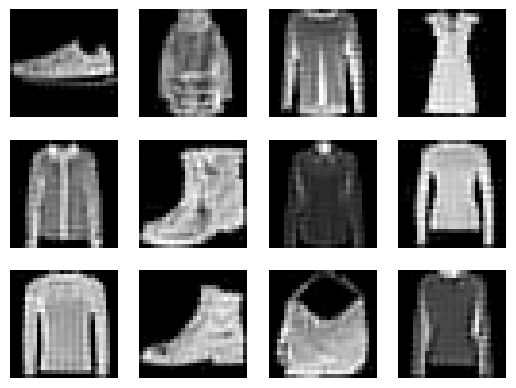

In [ ]:
yhat = ae_model(x.to(device)).to('cpu').detach()
show_images(yhat[:12])

# Get attr, setattr, itemgetter, attrgetter, methodcaller

In [ ]:
getattr

<function getattr>

In [ ]:
torch

<module 'torch' from '/usr/local/lib/python3.10/dist-packages/torch/__init__.py'>

In [ ]:
nn = getattr(torch, 'nn', None)

In [ ]:
setattr

<function setattr(obj, name, value, /)>

In [ ]:
class Test:
  def __init__(self):
    print('done')

In [ ]:
a = Test()
setattr(a, 'some', 'shit')

done


In [ ]:
a.some

'shit'

In [ ]:
getattr(a, 'sokme', 'iiindinf')

'iiindinf'

In [ ]:
def get_evens():
  i = 0
  while i < 100:
    if i%2 == 0: yield i
    i += 1

In [ ]:
gen = get_evens()

In [ ]:
gen

<generator object get_evens at 0x7a17949bac00>

In [ ]:
from operator import itemgetter, attrgetter, methodcaller

In [ ]:
f = itemgetter(3)

In [ ]:
f(list(gen))

6

In [ ]:
slice(1, None, 3)

slice(1, None, 3)

In [ ]:
l = [1, 2, 3, 4, 5, 6]
l[slice(1, 4)]

[2, 3, 4]

In [ ]:
itemgetter(slice(1, 3))(l)

[2, 3]

In [ ]:
f = itemgetter('k1', 'k2')
f({'k1': 2, 'k2': 4})

(2, 4)

In [ ]:
a.__dict__

{'some': 'shit'}

In [ ]:
class Test:
  def __init__(self):
    print('done')

In [ ]:
class New(Test):
  def test_fun(self, *args, **kwargs):
    print(f'Testing is cool, {args}, {kwargs}')

In [ ]:
o = New()

done


In [ ]:
mc = methodcaller('test_fun', 1, 2, 3, 4, 5, 6, some = 'shit', idk = 'nothing')

In [ ]:
mc(o)

Testing is cool, (1, 2, 3, 4, 5, 6), {'some': 'shit', 'idk': 'nothing'}


# Experiments with Learner - Basic code

In [ ]:
x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [ ]:
def new(some_data):
  def transform(some_data):
    some_data['image'] = [to_tensor(i) for i in some_data['image']]
  transform(some_data)

  return some_data

In [ ]:
dsd

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [ ]:
tds = dsd.with_transform(new)

In [ ]:
def collate_fn(some_data):
  sd = (i.values() for i in some_data)
  xs, ys = zip(*sd)
  return torch.stack(xs), torch.tensor(ys)

In [ ]:
from functools import partial
f = partial(DataLoader, batch_size = 64, collate_fn = collate_fn)

In [ ]:
train_dl, valid_dl = f(tds['train'], shuffle = True), f(tds['test'])

In [ ]:
class Learner:

  # init, fit, one_epoch, one_batch, calc_stats - Write new
  def __repr__(self):
    return f" model: {self.model} \n dls: {[train_dl, valid_dl]} \n opt: {self.opt} \n loss_fn: {self.loss_fn}"

  def __init__(self, model, train_dl, valid_dl, opt = optim.SGD, loss_fn = F.cross_entropy):
    fc.store_attr() # it will store all the attributes
    self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

  def fit(self, epochs = 100, opt = None, **kwargs):

    opt_fun = torch.optim.SGD if opt == None else opt
    self.opt = opt_fun(self.model.parameters(), **kwargs)
    self.model = self.model.to(self.device)
    for ep in tqdm(range(epochs)): self.one_epoch()

  def one_epoch(self):

    self.train_loss, self.valid_loss = [], []
    for x, y in self.train_dl: self.train_loss.append(self.one_batch(x.to(self.device), y.to(self.device), True))
    with torch.no_grad():
      for vx, vy in self.valid_dl: self.valid_loss.append(self.one_batch(vx.to(self.device), vy.to(self.device), False))
    print(f"train loss: {np.mean(self.train_loss):.3f}, valid_loss: {np.mean(self.valid_loss):.3f}")

  def one_batch(self, x, y, training = False):

    self.model.train() if training else self.model.eval()
    yhat = self.model(x)
    loss = self.loss_fn(yhat, y)
    if training:
      loss.backward()
      self.opt.step()
      self.opt.zero_grad()
    return loss.item()

In [ ]:
model =  nn.Sequential(
    conv(1, 4),  ## 8x14x14
    conv(4, 8), ## 16x7x7
    conv(8, 16), ## 32x4x4
    conv(16, 16), # 64x2x2x
    conv(16, 10, relu= False), # 128x1x1
    nn.Flatten(), # bs x 128
  )

In [ ]:
learner = Learner(model, train_dl, valid_dl)
learner.fit(2, lr = 0.4)

 50%|█████     | 1/2 [00:11<00:11, 11.51s/it]

train loss: 0.385, valid_loss: 0.459


100%|██████████| 2/2 [00:23<00:00, 11.51s/it]

train loss: 0.366, valid_loss: 0.417


In [ ]:
learner.device

device(type='cuda')

In [ ]:
class LearnerV2:

  def __repr__(self):
    return f" model: {self.model} \n dls: {[train_dl, valid_dl]} \n opt: {self.opt} \n loss_fn: {self.loss_fn}"

  def __init__(self, model, train_dl, valid_dl, opt = optim.SGD, loss_fn = F.cross_entropy):

    fc.store_attr()
    self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

  def store_stats(self):

    acc = ((self.y == self.yhat.argmax(1)).float().sum()/self.x.shape[0]).item()
    if self.model.training:
      self.train_loss.append(self.loss.item())
      self.train_accs.append(acc)
    else:
      self.valid_loss.append(self.loss.item())
      self.valid_accs.append(acc)

  def calc_stats(self):

    print({
        'train_loss': np.mean(self.train_loss),
        'train_accs': np.mean(self.train_accs),
        'valid_loss': np.mean(self.valid_loss),
        'valid_accs': np.mean(self.valid_accs)
    })

  def fit(self, epochs = 100, opt = None, **kwargs):

    opt_fun = torch.optim.SGD if opt == None else opt
    self.opt = opt_fun(self.model.parameters(), **kwargs)
    self.model = self.model.to(self.device)
    for ep in tqdm(range(epochs)): self.one_epoch()

  def one_epoch(self):

    self.train_loss, self.valid_loss, self.train_accs, self.valid_accs = [], [], [], []
    for x, y in self.train_dl: self.one_batch(x.to(self.device), y.to(self.device), True)
    with torch.no_grad():
      for vx, vy in self.valid_dl: self.one_batch(vx.to(self.device), vy.to(self.device), False)
    self.calc_stats()

  def one_batch(self, x, y, training = False):

    self.x, self.y = x, y
    self.model.train() if training else self.model.eval()
    self.yhat = self.model(self.x)
    self.loss = self.loss_fn(self.yhat, self.y)

    if training:
      self.loss.backward()
      self.opt.step()
      self.opt.zero_grad()

    self.store_stats()


In [ ]:
learner = LearnerV2(model, train_dl, valid_dl)
learner.fit(4, lr = 0.4)

 25%|██▌       | 1/4 [00:11<00:35, 11.97s/it]

train loss: {'train_loss': 0.36777676104990914, 'train_accs': 0.8648387526652452, 'valid_loss': 0.40972469044718773, 'valid_accs': 0.8525079617834395}


 50%|█████     | 2/4 [00:23<00:23, 11.79s/it]

train loss: {'train_loss': 0.36146924336518305, 'train_accs': 0.8655383795309168, 'valid_loss': 0.3903218951005085, 'valid_accs': 0.855593152866242}


 75%|███████▌  | 3/4 [00:35<00:11, 11.79s/it]

train loss: {'train_loss': 0.3566572162261141, 'train_accs': 0.8694029850746269, 'valid_loss': 0.3806497502099177, 'valid_accs': 0.8578821656050956}


100%|██████████| 4/4 [00:47<00:00, 11.81s/it]

train loss: {'train_loss': 0.3526476392709116, 'train_accs': 0.8686700426439232, 'valid_loss': 0.3888571958063514, 'valid_accs': 0.8538017515923567}


In [ ]:
class LearnerBeforeFitException(Exception): pass
class LearnerBeforeEpochException(Exception): pass
class LearnerAfterEpochException(Exception): pass
class LearnerBeforeBatchException(Exception): pass
class LearnerAfterBatchException(Exception): pass

In [ ]:
class LearnerCallback:

  def __init__(self):
    self.order = 0

  def before_fit(self, learner = None):
    try:
      print('Before Fit callback called')
      learner.model = learner.model.to(learner.device)
    except AttributeError as e:
      raise LearnerBeforeFitException(e)

  def before_epoch(self, learner = None):
    try:
      print('Before Epoch callback called')
      self.count = 0
    except Exception as e:
      raise LearnerBeforeEpochException(e)

  def after_epoch(self, learner = None):
    try:
      print(f'After Epoch callback called, total batches: {self.count}')
      learner.calc_stats()
    except AttributeError as e:
      raise LearnerAfterEpochException(e)

  def before_batch(self, learner = None):
    try:
      learner.x = learner.x.to(learner.device)
      learner.y = learner.y.to(learner.device)
    except AttributeError as e:
      raise LearnerBeforeBatchException(e)

  def after_batch(self, learner = None):
    try:
      self.count += 1
      learner.store_stats()
    except AttributeError as e:
      raise LearnerAfterBatchException(e)


In [ ]:
def run_cbs(cb_obj, name_of_func, *args, **kwargs):
  func = getattr(cb_obj, name_of_func, None)
  if func: func(*args, **kwargs)

In [ ]:
class LearnerV3:

  def __repr__(self):
    return f" model: {self.model} \n dls: {[train_dl, valid_dl]} \n opt: {self.opt} \n loss_fn: {self.loss_fn}"

  def __init__(self, model, train_dl, valid_dl, cbs, opt = optim.SGD, loss_fn = F.cross_entropy):

    fc.store_attr()
    self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

  def store_stats(self):

    acc = ((self.y == self.yhat.argmax(1)).float().sum()/self.x.shape[0]).item()
    if self.model.training:
      self.train_loss.append(self.loss.item())
      self.train_accs.append(acc)
    else:
      self.valid_loss.append(self.loss.item())
      self.valid_accs.append(acc)

  def calc_stats(self):

    print({
        'train_loss': np.mean(self.train_loss),
        'train_accs': np.mean(self.train_accs),
        'valid_loss': np.mean(self.valid_loss),
        'valid_accs': np.mean(self.valid_accs)
    })

  def fit(self, epochs = 100, opt = None, **kwargs):

    run_cbs(self.cbs, 'before_fit', self)
    opt_fun = torch.optim.SGD if opt == None else opt
    self.opt = opt_fun(self.model.parameters(), **kwargs)
    for ep in tqdm(range(epochs)): self.one_epoch()
    run_cbs(self.cbs, 'after_fit', self)

  def one_epoch(self):

    run_cbs(self.cbs, 'before_epoch', self)
    self.train_loss, self.valid_loss, self.train_accs, self.valid_accs = [], [], [], []
    for x, y in self.train_dl: self.one_batch(x, y, True)
    with torch.no_grad():
      for vx, vy in self.valid_dl: self.one_batch(vx, vy, False)
    run_cbs(self.cbs, 'after_epoch', self)

  def one_batch(self, x, y, training = False):

    self.x, self.y = x, y
    run_cbs(self.cbs, 'before_batch', self)
    self.model.train() if training else self.model.eval()
    self.yhat = self.model(self.x)
    self.loss = self.loss_fn(self.yhat, self.y)

    if training:
      self.loss.backward()
      self.opt.step()
      self.opt.zero_grad()

    run_cbs(self.cbs, 'after_batch', self)


In [ ]:
learner = LearnerV3(model, train_dl, valid_dl, LearnerCallback())
learner.fit(4, lr = 0.4)

Before Fit callback called


  0%|          | 0/4 [00:00<?, ?it/s]

Before Epoch callback called


 25%|██▌       | 1/4 [00:11<00:35, 11.90s/it]

After Epoch callback called, total batches: 1095
{'train_loss': 0.3388607440504438, 'train_accs': 0.8753164978678039, 'valid_loss': 0.44033848128880665, 'valid_accs': 0.8388734076433121}
Before Epoch callback called


 50%|█████     | 2/4 [00:23<00:23, 11.95s/it]

After Epoch callback called, total batches: 1095
{'train_loss': 0.33857758509229496, 'train_accs': 0.874933368869936, 'valid_loss': 0.3943704639080983, 'valid_accs': 0.8542993630573248}
Before Epoch callback called


 75%|███████▌  | 3/4 [00:35<00:11, 11.93s/it]

After Epoch callback called, total batches: 1095
{'train_loss': 0.33227800741505775, 'train_accs': 0.8766491204690832, 'valid_loss': 0.4091026976609686, 'valid_accs': 0.8444466560509554}
Before Epoch callback called


100%|██████████| 4/4 [00:47<00:00, 11.89s/it]

After Epoch callback called, total batches: 1095
{'train_loss': 0.33280602386638297, 'train_accs': 0.8760327825159915, 'valid_loss': 0.38522239712772854, 'valid_accs': 0.8595740445859873}


In [ ]:
class Metric:
  def __init__(self):
    self.reset()

  def reset(self):
    self.vals, self.ns = [], []

  def add(self, inp, targ, n = 1):
    self.last = self.calc(inp, targ)
    self.vals.append(self.last)
    self.ns.append(n)

  def calc(self, inp, targ):
    return inp

  @property
  def value(self):
    return (torch.tensor(self.ns)*torch.tensor(self.vals)).sum()/torch.tensor(self.ns).sum()

In [ ]:
class Accuracy(Metric):
  def calc(self, inp, targ):
    return (inp == targ).float().mean()

In [ ]:
acc = Accuracy()
acc.add(torch.tensor([1, 2, 3, 4, 5, 6]), torch.tensor([2,2, 3, 3, 5, 6]), n = 6)

In [ ]:
acc.value

tensor(0.6667)

In [ ]:
acc.add(torch.tensor([1, 2, 3, 4, 5, 6]), torch.tensor([1,2, 3, 3, 5, 6]), n = 6)

In [ ]:
acc.value

tensor(0.7500)

# Little Deep Into Callbacks

In [ ]:
from torcheval.metrics import MulticlassAccuracy, Mean
from collections.abc import Mapping

In [72]:
def to_device(data, device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')):
  return data.to(device)

In [73]:
def run_cbs(cbs, name_of_func, *args, **kwargs):

  for cb in sorted(cbs, key = attrgetter('order')):
    func = getattr(cb, name_of_func, None)
    if func: func(*args, **kwargs)

In [74]:
def to_cpu(x):
  if isinstance(x, Mapping): return {k: to_cpu(v) for k, v in x.items()}
  if isinstance(x, list): return [to_cpu(i) for i in x]
  if isinstance(x, tuple): return tuple([to_cpu(i) for i in x])
  x = x.detach().cpu()
  return x.float() if x.dtype == torch.float16 else x

In [ ]:
# create Metrics callback - that takes all the metrics and do one by one and a device callbacks - to load the elements onto the device
class MetricsCB(Callback):
  def __init__(self, **metrics):
    self.order = 1
    self.loss = Mean()
    self.all_metrics = metrics

  def _log(self, d):
    print(d)

  def before_fit(self, learner):
    learner.metrics = self

  def after_fit(self, learner):
    pass

  def before_epoch(self, learner):
    [i.reset() for i in self.all_metrics.values()]

  def after_epoch(self, learner):
    dd = {k: f"{v.compute(): .3f}" for k, v in self.all_metrics.items()}
    dd['loss'] = f"{self.loss.compute(): .3f}"
    dd['phase'] = 'train' if learner.model.training else 'eval'
    self._log(dd)

  def after_batch(self, learner):
    x, y, yhat = to_cpu((learner.x, learner.y, learner.yhat))

    for m in self.all_metrics.values():
      m.update(yhat, y)

    self.loss.update(to_cpu(learner.loss), weight=len(x))


In [14]:
class DeviceCB(Callback):
  def __init__(self):
    self.order = 0
    self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  def before_fit(self, learn):
    if hasattr(learn, 'model'): learn.model = to_device(learn.model, self.device)

  def after_fit(self, learn):
    pass

  def before_epoch(self, learn):
    pass

  def after_epoch(self, learn):
    pass

  def before_batch(self, learn):
    learn.x, learn.y = to_device(learn.x, self.device), to_device(learn.y, self.device)

In [ ]:
model =  nn.Sequential(
    conv(1, 4),  ## 8x14x14
    conv(4, 8), ## 16x7x7
    conv(8, 16), ## 32x4x4
    conv(16, 16), # 64x2x2x
    conv(16, 10, relu= False), # 128x1x1
    nn.Flatten(), # bs x 128
  )

In [ ]:
class LearnerV4:

  def __repr__(self):
    return f" model: {self.model} \n dls: {[train_dl, valid_dl]} \n opt: {self.opt} \n loss_fn: {self.loss_fn}"

  def __init__(self, model, train_dl, valid_dl, cbs, opt = optim.SGD, loss_fn = F.cross_entropy):

    fc.store_attr()
    self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

  def fit(self, epochs = 100, opt = None, **kwargs):

    run_cbs(self.cbs, 'before_fit', self)
    opt_fun = torch.optim.SGD if opt == None else opt
    self.opt = opt_fun(self.model.parameters(), **kwargs)
    for ep in tqdm(range(epochs)): self.one_epoch()
    run_cbs(self.cbs, 'after_fit', self)

  def one_epoch(self):

    run_cbs(self.cbs, 'before_epoch', self)
    self.train_loss, self.valid_loss, self.train_accs, self.valid_accs = [], [], [], []
    for x, y in self.train_dl: self.one_batch(x, y, True)
    with torch.no_grad():
      for vx, vy in self.valid_dl: self.one_batch(vx, vy, False)
    run_cbs(self.cbs, 'after_epoch', self)

  def one_batch(self, x, y, training = False):

    self.x, self.y = x, y
    run_cbs(self.cbs, 'before_batch', self)
    self.model.train() if training else self.model.eval()
    self.yhat = self.model(self.x)
    self.loss = self.loss_fn(self.yhat, self.y)

    if training:
      self.loss.backward()
      self.opt.step()
      self.opt.zero_grad()

    run_cbs(self.cbs, 'after_batch', self)


In [ ]:
learner = LearnerV4(model, train_dl, valid_dl, [DeviceCB(), MetricsCB(acc = MulticlassAccuracy())])

In [ ]:
learner.fit( 2, lr = 0.4)

 50%|█████     | 1/2 [00:20<00:20, 20.80s/it]

{'acc': ' 0.723', 'loss': ' 0.750', 'phase': 'eval'}


100%|██████████| 2/2 [00:40<00:00, 20.25s/it]

{'acc': ' 0.827', 'loss': ' 0.607', 'phase': 'eval'}


# Flexible Learner

In [8]:
class with_cbs:
  def __init__(self, nm):
    self.nm = nm

  def __call__(self, f):
    def _f(o, *args, **kwargs):
      o.callback(f"before_{self.nm}")
      f(o, *args, **kwargs)
      o.callback(f"after_{self.nm}")
    return _f

In [15]:
class LearnerV5:

  def __repr__(self):
    return f" model: {self.model} \n dls: {[train_dl, valid_dl]} \n opt: {self.opt} \n loss_fn: {self.loss_fn}"

  def __init__(self, model, train_dl, valid_dl, cbs, opt = optim.SGD, loss_fn = F.cross_entropy): fc.store_attr()

  @property
  def training(self): return self.model.training

  @with_cbs('fit')
  def fit(self, epochs = 100, opt = None, **kwargs):

    opt_fun = torch.optim.SGD if opt == None else opt
    self.opt = opt_fun(self.model.parameters(), **kwargs)
    for ep in tqdm(range(epochs)): self.one_epoch()

  @with_cbs('epoch')
  def one_epoch(self):

    self.model.train()
    self._one_epoch(self.train_dl)
    self.model.eval()
    with torch.no_grad(): self._one_epoch(self.valid_dl)

  def _one_epoch(self, dl):
    for x, y in dl:
      self.x, self.y = x, y
      self.one_batch()

  @with_cbs('batch')
  def one_batch(self):

    self.yhat = self.model(self.x)
    self.loss = self.loss_fn(self.yhat, self.y)

    if self.training:
      self.loss.backward()
      self.opt.step()
      self.opt.zero_grad()

  def callback(self, nm): run_cbs(self.cbs, nm, self)

In [237]:
# learner = LearnerV5(model, train_dl, valid_dl, [DeviceCB(), MetricsCB(acc = MulticlassAccuracy())])
# learner.fit( 2, lr = 0.4)

In [238]:
# Add more callbacks - Like progress callback - IDK what it does?

# what do I require while I'm training the model

# 0. Prior to everything, lets create a context manager callback arch, so that we can design the callbacks based on that.
# 1. I want to store epoch wise performance - Done in metrics class and stored in history object of that class.
# 2. Introduce graphical elements - progress_callback - plot losses of that particular fit call - both train and valid
# 3. create an lr find method for the learner to find the learning rate
# 4. save the model after every epoch
# 5. save the model when ever we get the best losses.
# 6. create a callback to find the best learning rate and update the learning rate in optim after every epoch

# So, basically I have to write handler functions - performance handler is the first one here.
# Performance Handler - Records the performance of the model - Keeps track of all the metrics, What learning rate yielded the best results.
# So, it should have cycles - n cycles - each cycle has a reset function to stop that cycle and start a new one.
# general performance metrics - like what are the performance metrics that we want to calculate
#    - MultiClassAccuracy,
#    - F1Score, basic loss
#    - Mean Metric of the loss
# So, here we require 2 classes, one is metrics class and other is performance class.


In [55]:
class StoreMetrics(Callback):
  def __init__(self, **ms):
    self.metrics, self.loss_metric = {k:v() for k, v in ms.items()}, Mean()
    self.history, self.train_losses, self.valid_losses  = [], [], []
    self.learn = None

  @property
  def results(self):
    dd = {k: metric.compute() for k, metric in self.metrics.items()}
    dd['loss'], dd['epoch'], dd['lr'], dd['mode'] = self.loss_metric.compute(), self.learn.epoch, self.learn.opt.param_groups[0]['lr'], 'train' if self.learn.training else 'eval'
    self.history.append(dd)
    return dd

  def after_batch(self, learn):
    yhat, y, loss = to_cpu((self.learn.yhat, self.learn.y, self.learn.loss))
    self.train_losses.append(loss) if self.learn.training else self.valid_losses.append(loss)
    for k, metric in self.metrics.items(): metric.update(yhat, y)
    self.loss_metric.update(loss)

  def _log(self, dd):
    print(dd)

  def after_epoch(self, learn):
    self._log(self.results)

  def before_epoch(self, learn):
    [i.reset() for i in list(self.metrics.values()) + [self.loss_metric]]

  def before_fit(self, learn):
    if not self.learn: self.learn = learn
    self.train_losses, self.valid_losses  = [], []

class pd:
  def __init__(self, *args): pass

  def __call__(self, f):
    # st()
    self.nm = f.__name__
    def _f(o, *args, **kwargs):
      methodcaller(self.nm, *args, **kwargs)(o.metrics)
      f(o, *args, **kwargs)
    return _f

class ProgressCallback(Callback):
  def __init__(self, metrics_class = StoreMetrics, **ms):
    fc.store_attr()
    self.ms = ms
    self.metrics, self.prev = self.intantiate(), []
    self.learn = None

  def intantiate(self):
    return self.metrics_class(**self.ms)

  @pd()
  def after_batch(self, learn): pass

  @pd()
  def after_epoch(self, learn): pass

  @pd()
  def before_epoch(self, learn): pass

  @pd()
  def before_fit(self, learn): self.learn = learn

  def after_fit(self, learn): self.plot()

  def reset(self, learn):
    self.prev.append(self.metrics)
    self.metrics = self.intantiate()

  def _log(self, dd): print(dd)

  def summary(self, learn):
    self._log(self.metrics.history)

  def history(self, learn):
    self._log([i.history for i in self.prev])

  def plot(self, *args, **kwargs):
    tl, vl = self.metrics.train_losses, self.metrics.valid_losses
    self._plot(tl, vl)

  def _plot(self, *args):
    for a in args:
      plt.plot(a)

In [35]:
model =  nn.Sequential(
    conv(1, 4),  ## 8x14x14
    conv(4, 8), ## 16x7x7
    conv(8, 16), ## 32x4x4
    conv(16, 16), # 64x2x2x
    conv(16, 10, relu= False), # 128x1x1
    nn.Flatten(), # bs x 128
  )

In [36]:
class with_cbs:
  def __init__(self, nm):
    self.nm = nm

  def __call__(self, f):

    def _f(o, *args, **kwargs):
      # st()
      o.callback(f"before_{self.nm}")
      f(o, *args, **kwargs)
      o.callback(f"after_{self.nm}")
    return _f

In [46]:
class LearnerV6:

  def __repr__(self):
    return f" model: {self.model} \n dls: {[train_dl, valid_dl]} \n opt: {self.opt} \n loss_fn: {self.loss_fn}"

  def __init__(self, model, train_dl, valid_dl, cbs, opt = optim.SGD, loss_fn = F.cross_entropy): fc.store_attr()

  @property
  def training(self): return self.model.training

  @with_cbs('fit')
  def fit(self, epochs = 100, opt = None, **kwargs):
    # st()
    opt_fun = torch.optim.SGD if opt == None else opt
    self.opt = opt_fun(self.model.parameters(), **kwargs)
    for self.epoch in tqdm(range(epochs)) : self.one_epoch()

  def one_epoch(self):

    self.model.train()
    self._one_epoch(self.train_dl)
    self.model.eval()
    with torch.no_grad(): self._one_epoch(self.valid_dl)

  @with_cbs('epoch')
  def _one_epoch(self, dl):
    for self.batch_num, (self.x, self.y) in enumerate(dl): self.one_batch()

  @with_cbs('batch')
  def one_batch(self):

    self.yhat = self.model(self.x)
    self.loss = self.loss_fn(self.yhat, self.y)

    if self.training:
      self.loss.backward()
      self.opt.step()
      self.opt.zero_grad()

  def lr_find(self): pass

  def __getattr__(self, nm):
    if nm in ['plot', 'history', "summary"]:
      return partial(self.callback, nm)
    raise AttributeError(name)

  def callback(self, nm): run_cbs(self.cbs, nm, self)

In [47]:
learner = LearnerV6(model, train_dl, valid_dl, cbs = [DeviceCB(), ProgressCallback(acc = MulticlassAccuracy, f1_score = MulticlassF1Score)])

  0%|          | 0/2 [00:00<?, ?it/s]

{'acc': tensor(0.8681), 'f1_score': tensor(0.8681), 'loss': tensor(0.3537, dtype=torch.float64), 'epoch': 0, 'lr': 0.3, 'mode': 'train'}


 50%|█████     | 1/2 [00:21<00:21, 21.04s/it]

{'acc': tensor(0.8562), 'f1_score': tensor(0.8562), 'loss': tensor(0.3952, dtype=torch.float64), 'epoch': 0, 'lr': 0.3, 'mode': 'eval'}
{'acc': tensor(0.8717), 'f1_score': tensor(0.8717), 'loss': tensor(0.3488, dtype=torch.float64), 'epoch': 1, 'lr': 0.3, 'mode': 'train'}


100%|██████████| 2/2 [00:39<00:00, 19.74s/it]

{'acc': tensor(0.8547), 'f1_score': tensor(0.8547), 'loss': tensor(0.4147, dtype=torch.float64), 'epoch': 1, 'lr': 0.3, 'mode': 'eval'}


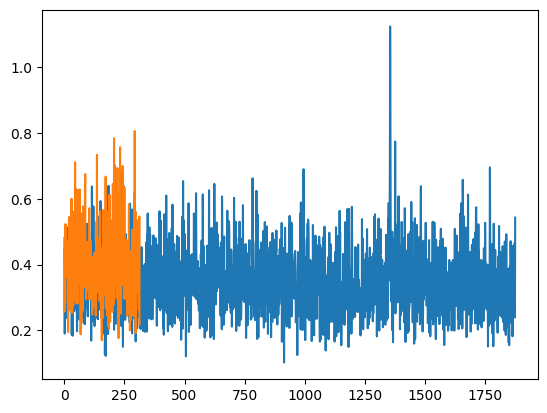

In [48]:
learner.fit(2, lr = 0.3)

In [49]:
learner.summary()

In [54]:
learner.cbs[1].metrics.history

[{'acc': tensor(0.8681),
  'f1_score': tensor(0.8681),
  'loss': tensor(0.3537, dtype=torch.float64),
  'epoch': 0,
  'lr': 0.3,
  'mode': 'train'},
 {'acc': tensor(0.8562),
  'f1_score': tensor(0.8562),
  'loss': tensor(0.3952, dtype=torch.float64),
  'epoch': 0,
  'lr': 0.3,
  'mode': 'eval'},
 {'acc': tensor(0.8717),
  'f1_score': tensor(0.8717),
  'loss': tensor(0.3488, dtype=torch.float64),
  'epoch': 1,
  'lr': 0.3,
  'mode': 'train'},
 {'acc': tensor(0.8547),
  'f1_score': tensor(0.8547),
  'loss': tensor(0.4147, dtype=torch.float64),
  'epoch': 1,
  'lr': 0.3,
  'mode': 'eval'}]

In [ ]:
# lr find
# Lets start from least learning rate of 1e-04, increment that lr by 30 pct - Use learning rate scheduler
# Take only 10 batches of data - x, y
# create an existing copy of the model
# with no grad - fit the model for an epoch

In [ ]:
class LearnerV7:

  def __repr__(self):
    return f" model: {self.model} \n dls: {[train_dl, valid_dl]} \n opt: {self.opt} \n loss_fn: {self.loss_fn}"

  def __init__(self, model, train_dl, valid_dl, cbs, opt = optim.SGD, loss_fn = F.cross_entropy): fc.store_attr()

  @property
  def training(self): return self.model.training

  @with_cbs('fit')
  def fit(self, epochs = 100, opt = None, **kwargs):
    # st()
    opt_fun = torch.optim.SGD if opt == None else opt
    self.opt = opt_fun(self.model.parameters(), **kwargs)
    for self.epoch in tqdm(range(epochs)) : self.one_epoch()

  def one_epoch(self):

    self.model.train()
    self._one_epoch(self.train_dl)
    self.model.eval()
    with torch.no_grad(): self._one_epoch(self.valid_dl)

  @with_cbs('epoch')
  def _one_epoch(self, dl):
    for self.batch_num, (self.x, self.y) in enumerate(dl): self.one_batch()

  @with_cbs('batch')
  def one_batch(self):

    self.yhat = self.model(self.x)
    self.loss = self.loss_fn(self.yhat, self.y)

    if self.training:
      self.loss.backward()
      self.opt.step()
      self.opt.zero_grad()

  def lr_find(self):
    pass

  def __getattr__(self, nm):
    if nm in ['plot']:
      return partial(self.callback, nm)
    raise AttributeError(name)

  def callback(self, nm): run_cbs(self.cbs, nm, self)